In [1]:
import sys; sys.path.insert(0,'..')
from hashstash import *
logger.setLevel(logging.INFO)
from hashstash.profilers.engine_profiler import *

In [2]:
# get_dataset(100, 1000000)
# generate_dataset.stash.clear()

In [3]:
# x=get_dataset(1000, 1_00_000)
# x[0]

In [4]:
import pandas as pd
import plotnine as p9
p9.options.figure_size = (10,6)

def plot_iterations2(df, time_type='Total', iteration_range=(10, 5000),
                     rolling_window=100, point_interval=100, facet_by='Num Proc', color_by='Serializer', shape_by='Engine'):
    df = df.query(f'{iteration_range[0]}<Iteration<{iteration_range[1]}')
    df['Iteration Group'] = df['Iteration']

    figdf = df.groupby(['Iteration','Engine','Num Proc','Serializer']).median(numeric_only=True).reset_index()
    figdf['Num Proc'] = figdf['Num Proc'].astype(str)
    figdf['Cumulative Size (MB)'] = figdf['Cumulative Size (B)'] / 1024 / 1024
    figdf['Cumulative Size (GB)'] = figdf['Cumulative Size (MB)'] / 1024
    figdf[f'{time_type} Rate (it/s)'] = 1 / figdf[f'{time_type} Time (s)']
    figdf.sort_values('Iteration', inplace=True)
    figdf[f'{time_type} Rate (it/s) Rolling'] = pd.concat(
        gdf[f'{time_type} Rate (it/s)'].rolling(window=rolling_window).median()
        for _, gdf in figdf.groupby(['Engine', 'Num Proc', 'Serializer'])
    )

    fig = p9.ggplot(figdf, p9.aes(x='Iteration', y=f'{time_type} Rate (it/s) Rolling', color=color_by, shape=shape_by))
    fig += p9.geom_line(alpha=.5)
    fig += p9.geom_point(alpha=.25, data=figdf[figdf.Iteration % point_interval == 0])
    fig += p9.geom_text(
        p9.aes(label=color_by), data=pd.concat(dfx[-1:].sample(n=1) for g,dfx in figdf.groupby(['Engine','Num Proc','Serializer'])),
        size=8,
    )
    fig += p9.theme_classic()
    fig += p9.facet_wrap(facet_by, nrow=1, scales='free_y')
    # fig += p9.scale_y_log10()
    fig += p9.labs(title=f'{time_type} Rate (it/s) Rolling')
    return fig

# Example usage:
# plot_iterations2(df, time_type='Get', iteration_range=(5, 1000), serializer='jsonpickle', 
#                  rolling_window=50, point_interval=50, facet_by='Engine')

In [5]:
# df_serializers=pd.concat([
#     HashStashProfiler.run_profiles(1000, 1_000_000, progress_inner=True, num_proc=1, num_procs=[8], engines=['pairtree']),
#     HashStashProfiler.run_profiles(1000, 1_000_000, progress_inner=True, num_proc=8, num_procs=[1], engines=['pairtree'])
# ])

# plot_iterations2(df_serializers, time_type='Serialize', iteration_range=(5, 1000), rolling_window=50, point_interval=50, color_by='Serializer')


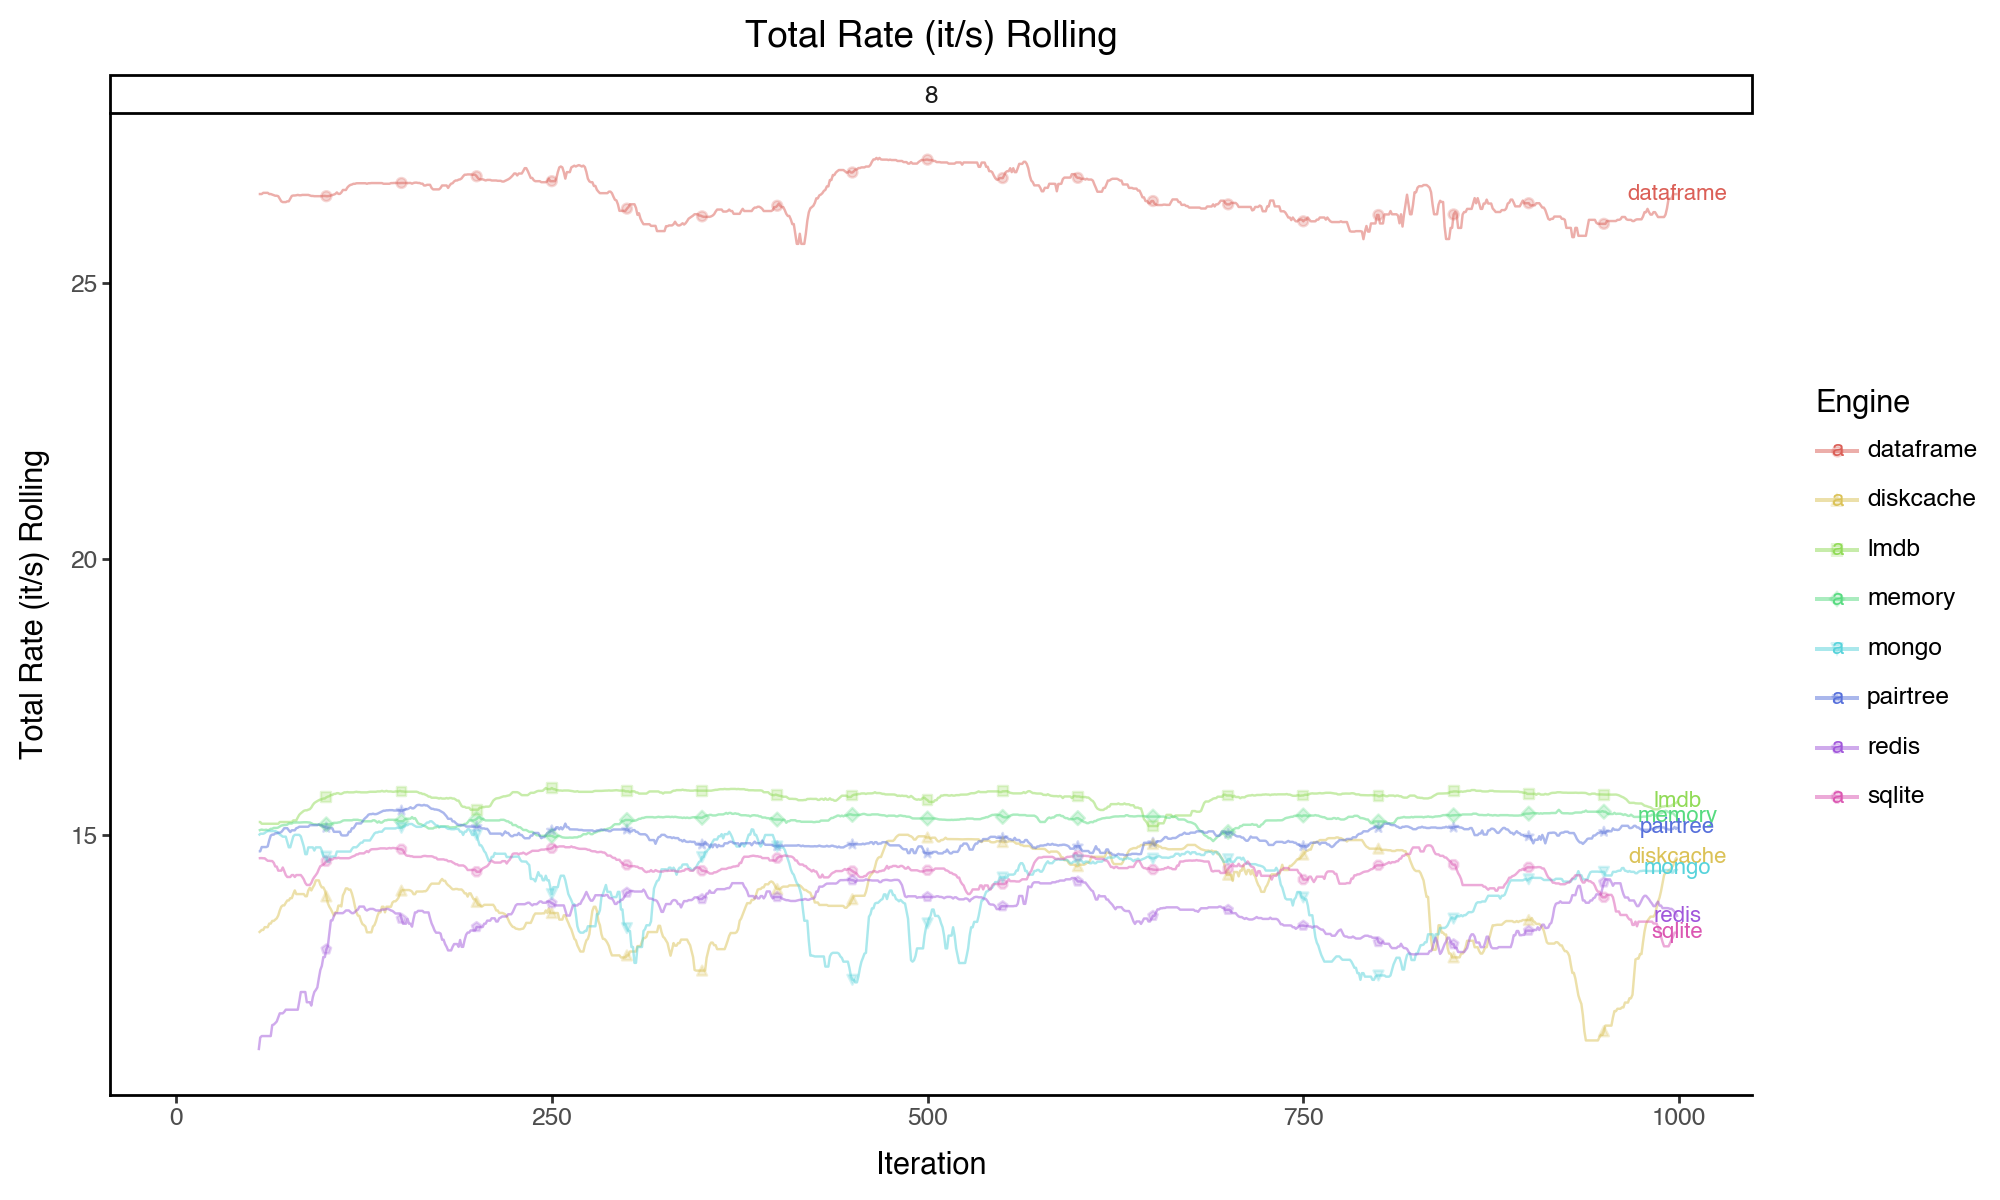

In [7]:
import pandas as pd
df_engines=pd.concat([
    HashStashProfiler.run_profiles(1000, 1_000_000, progress_inner=True, num_proc=1, num_procs=[8], serializers=['pickle'])
])
# df_engines = df_engines[df_engines["Engine"]!="dataframe"]

plot_iterations2(df_engines, time_type='Total', iteration_range=(5, 1000), rolling_window=50, point_interval=50, color_by='Engine')


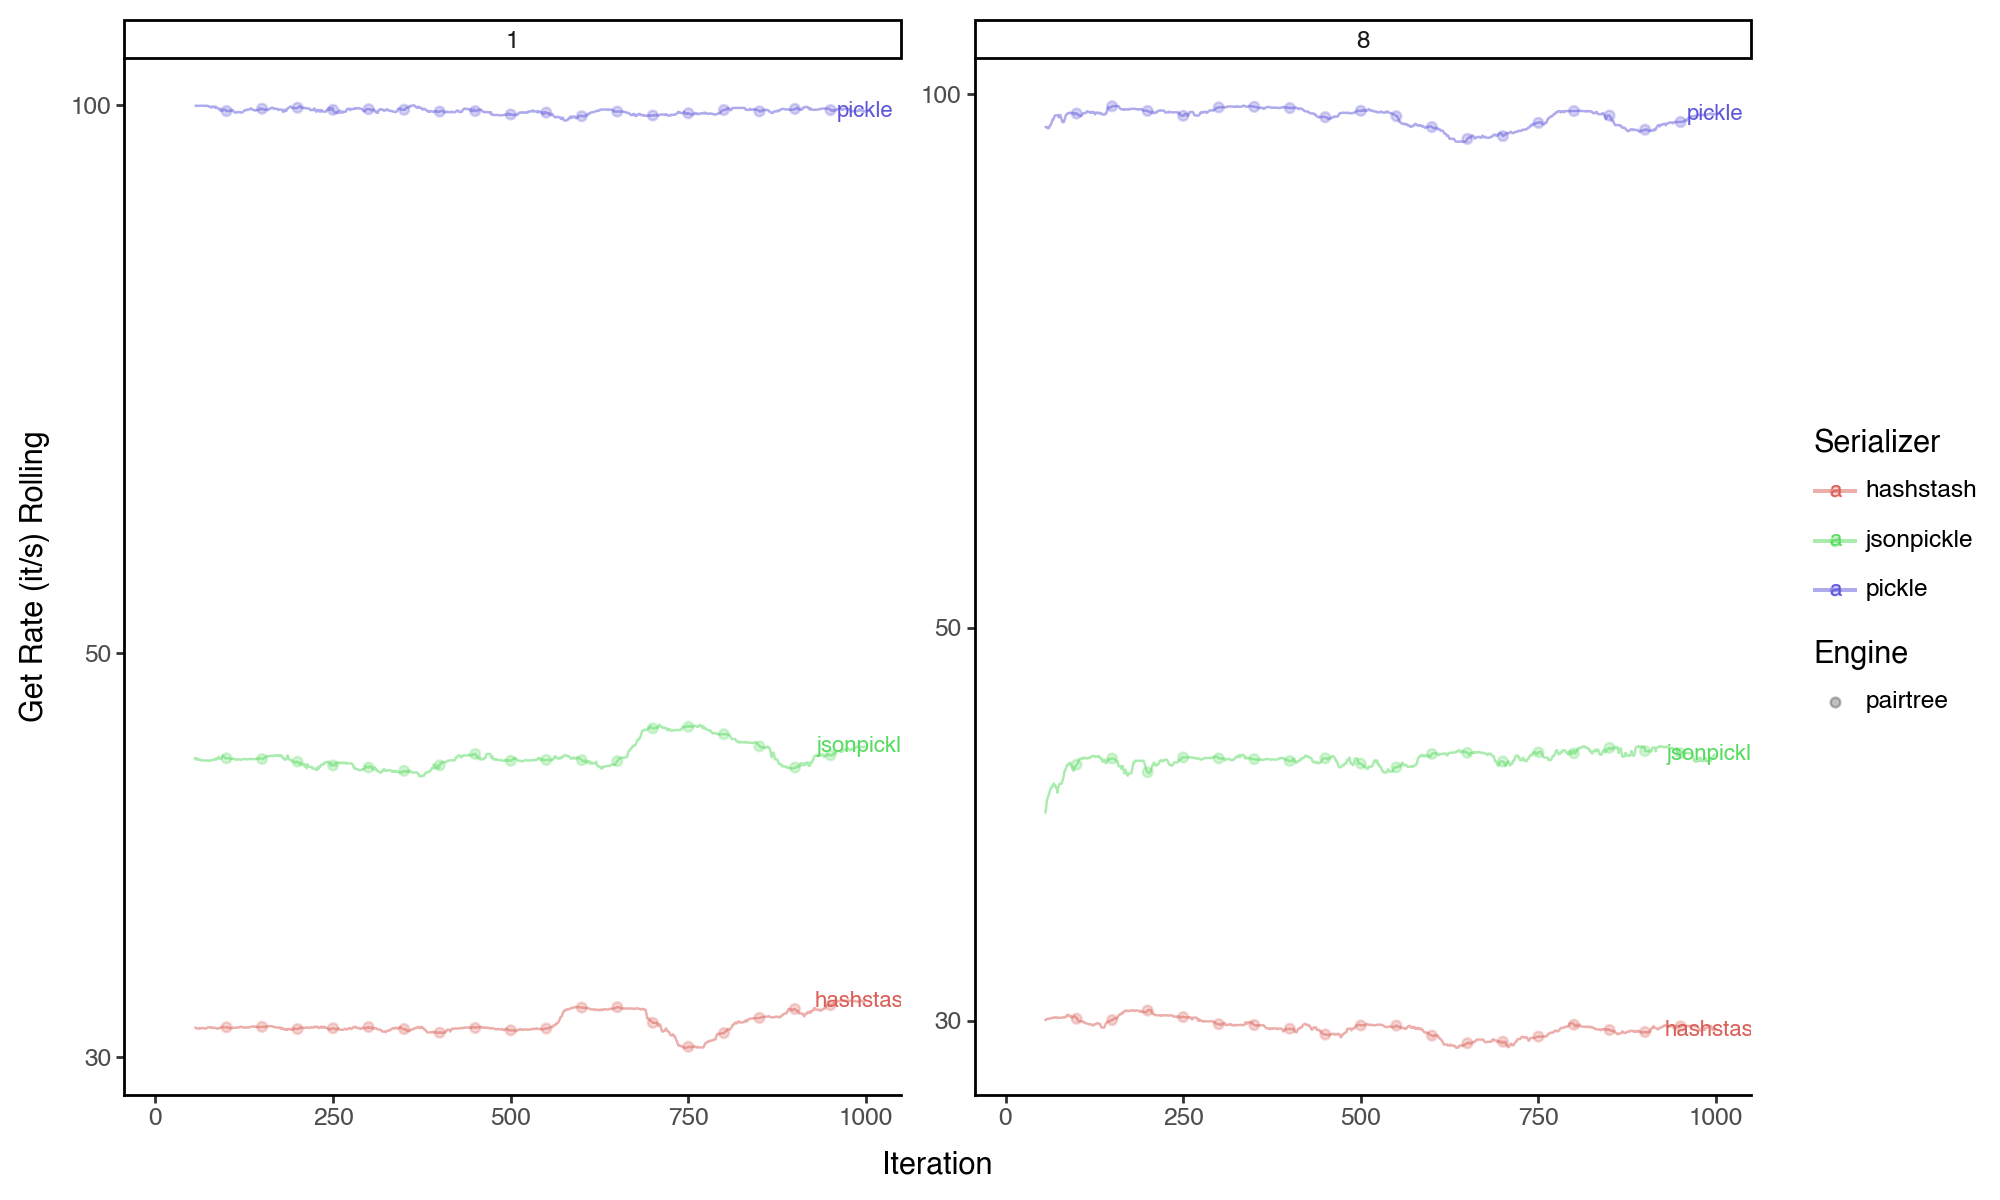

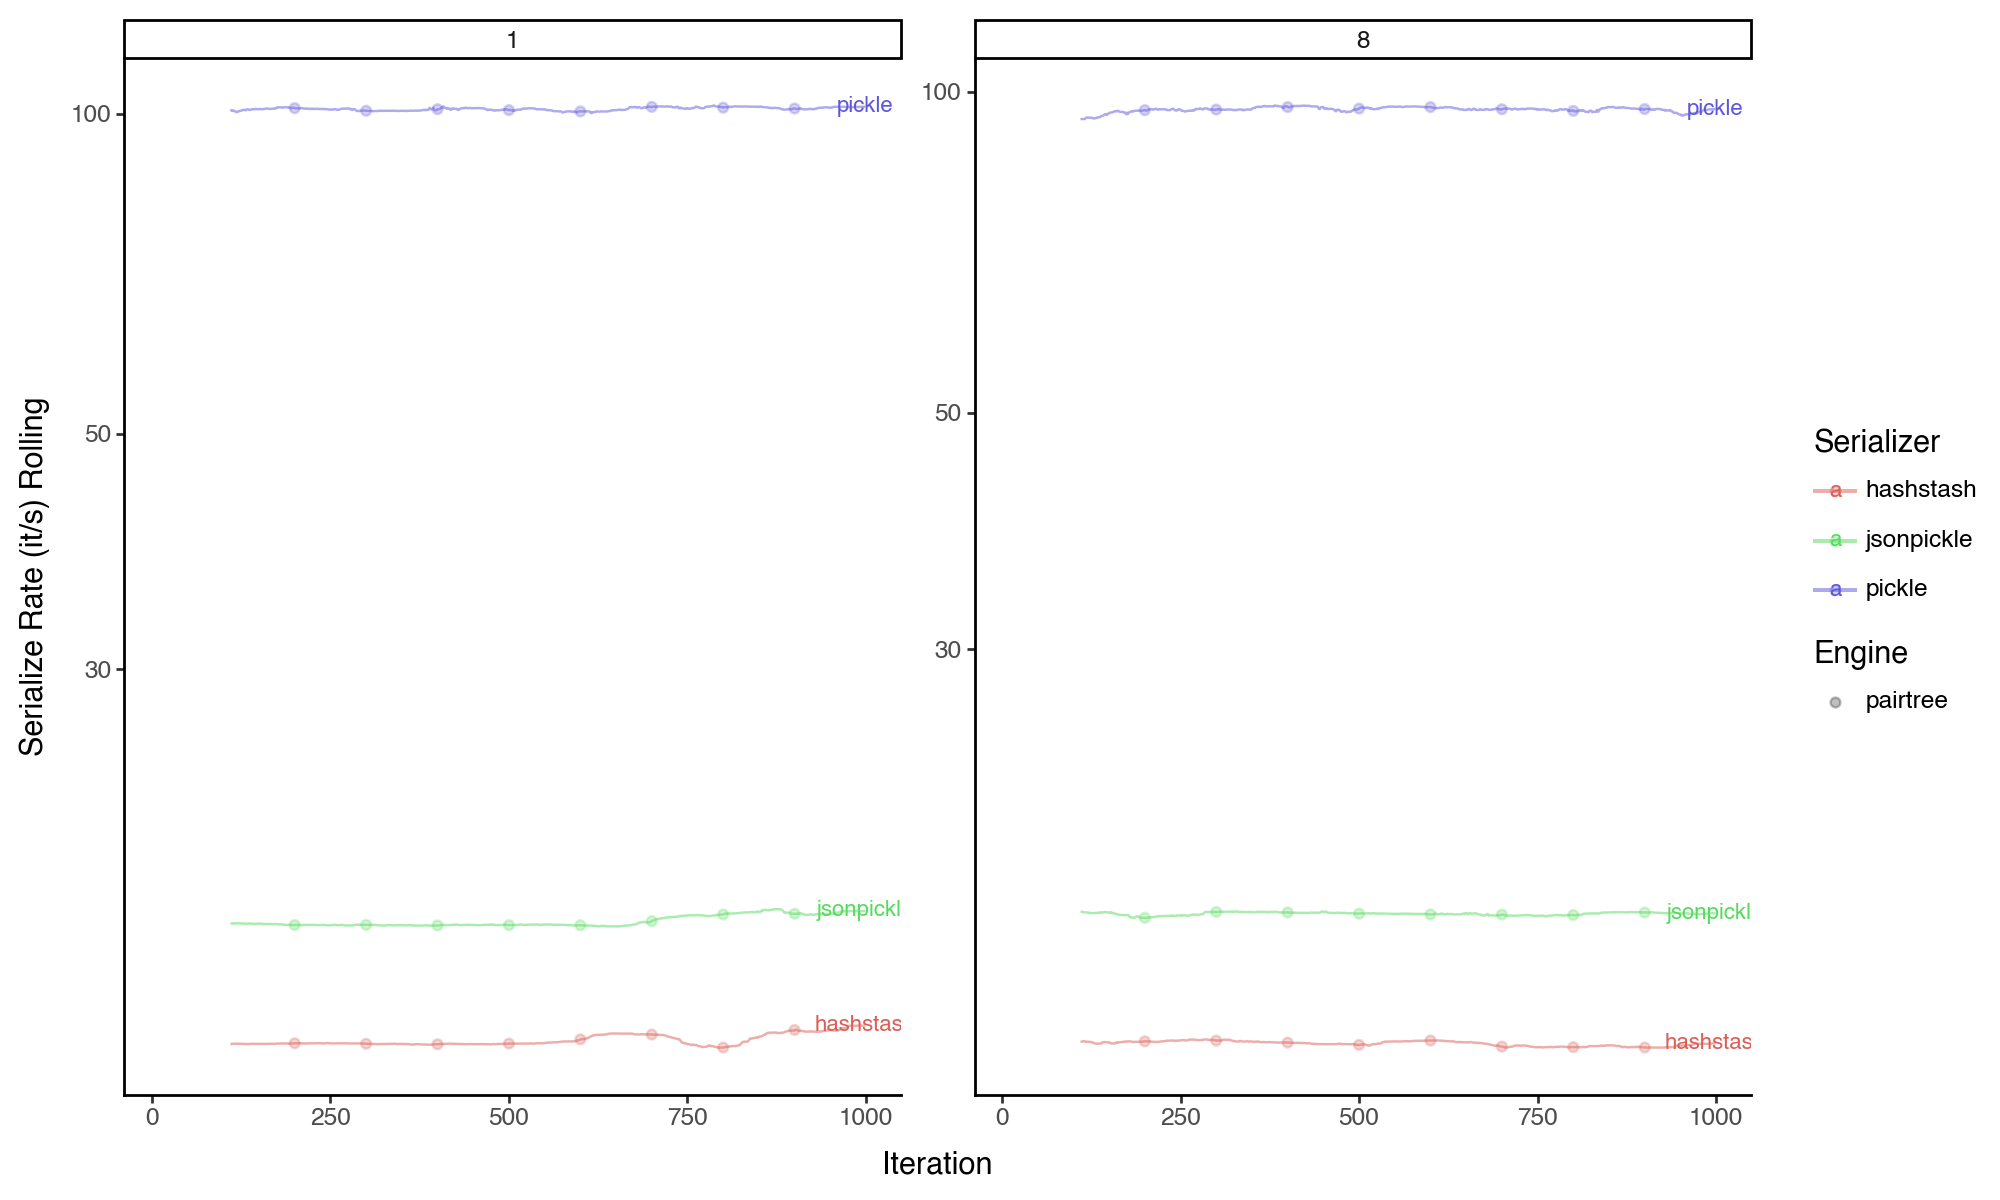

In [24]:
plot_iterations2(df,'Serialize')

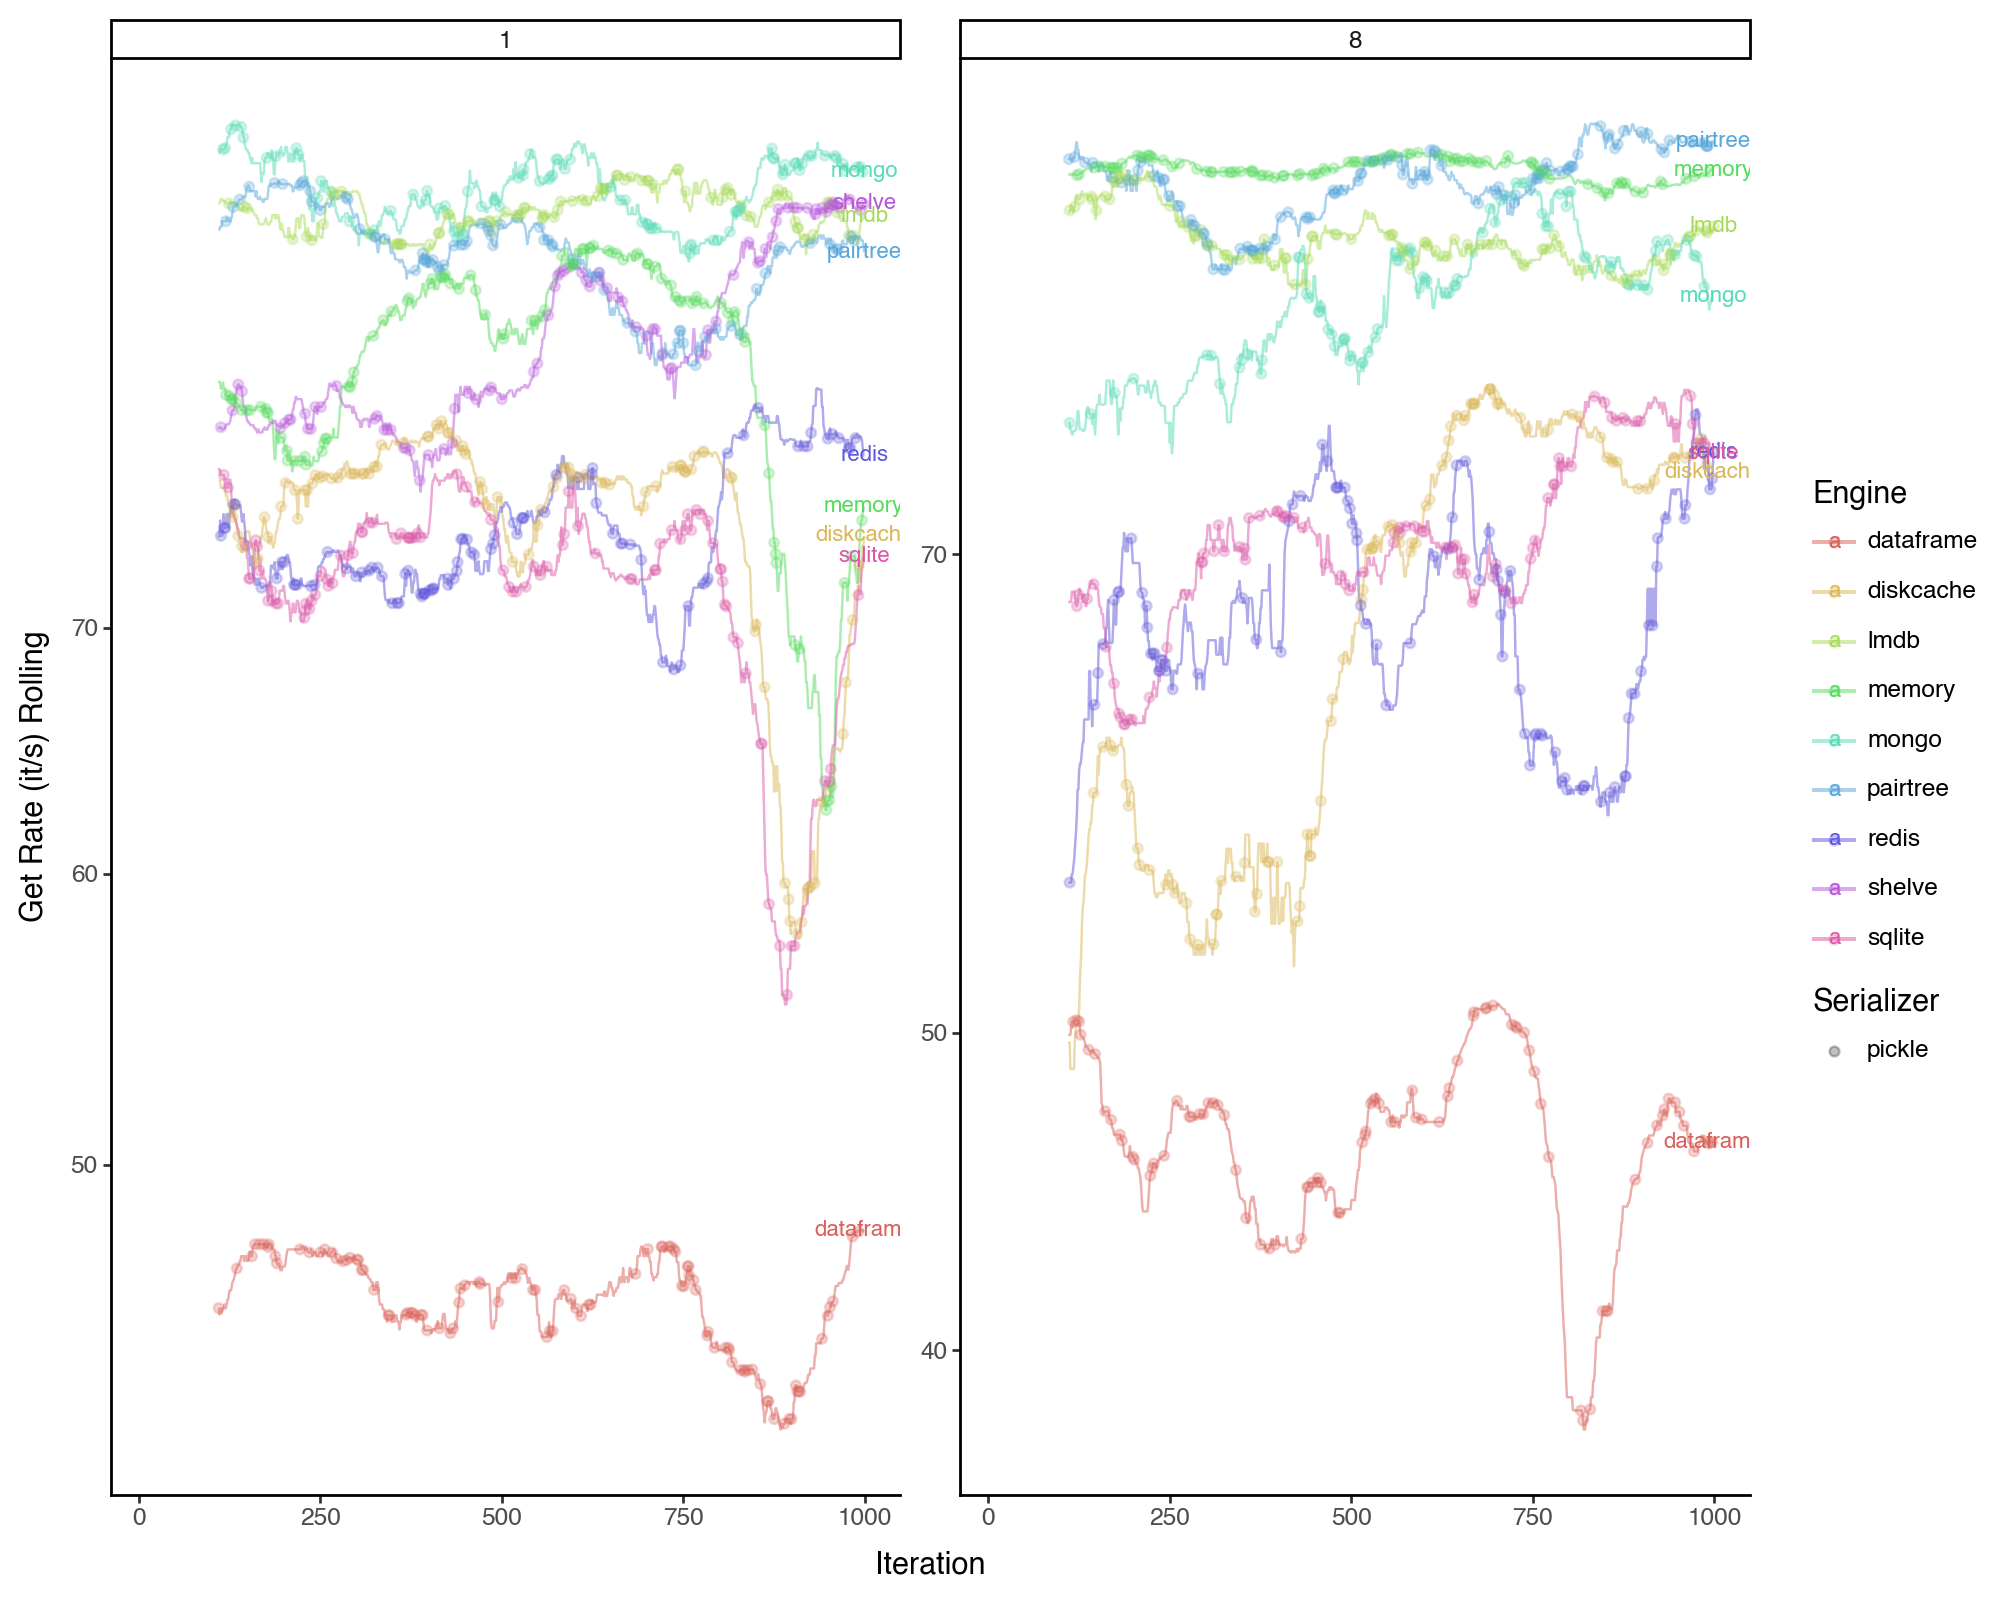

In [88]:
plot_iterations2(df, time_type='Get')

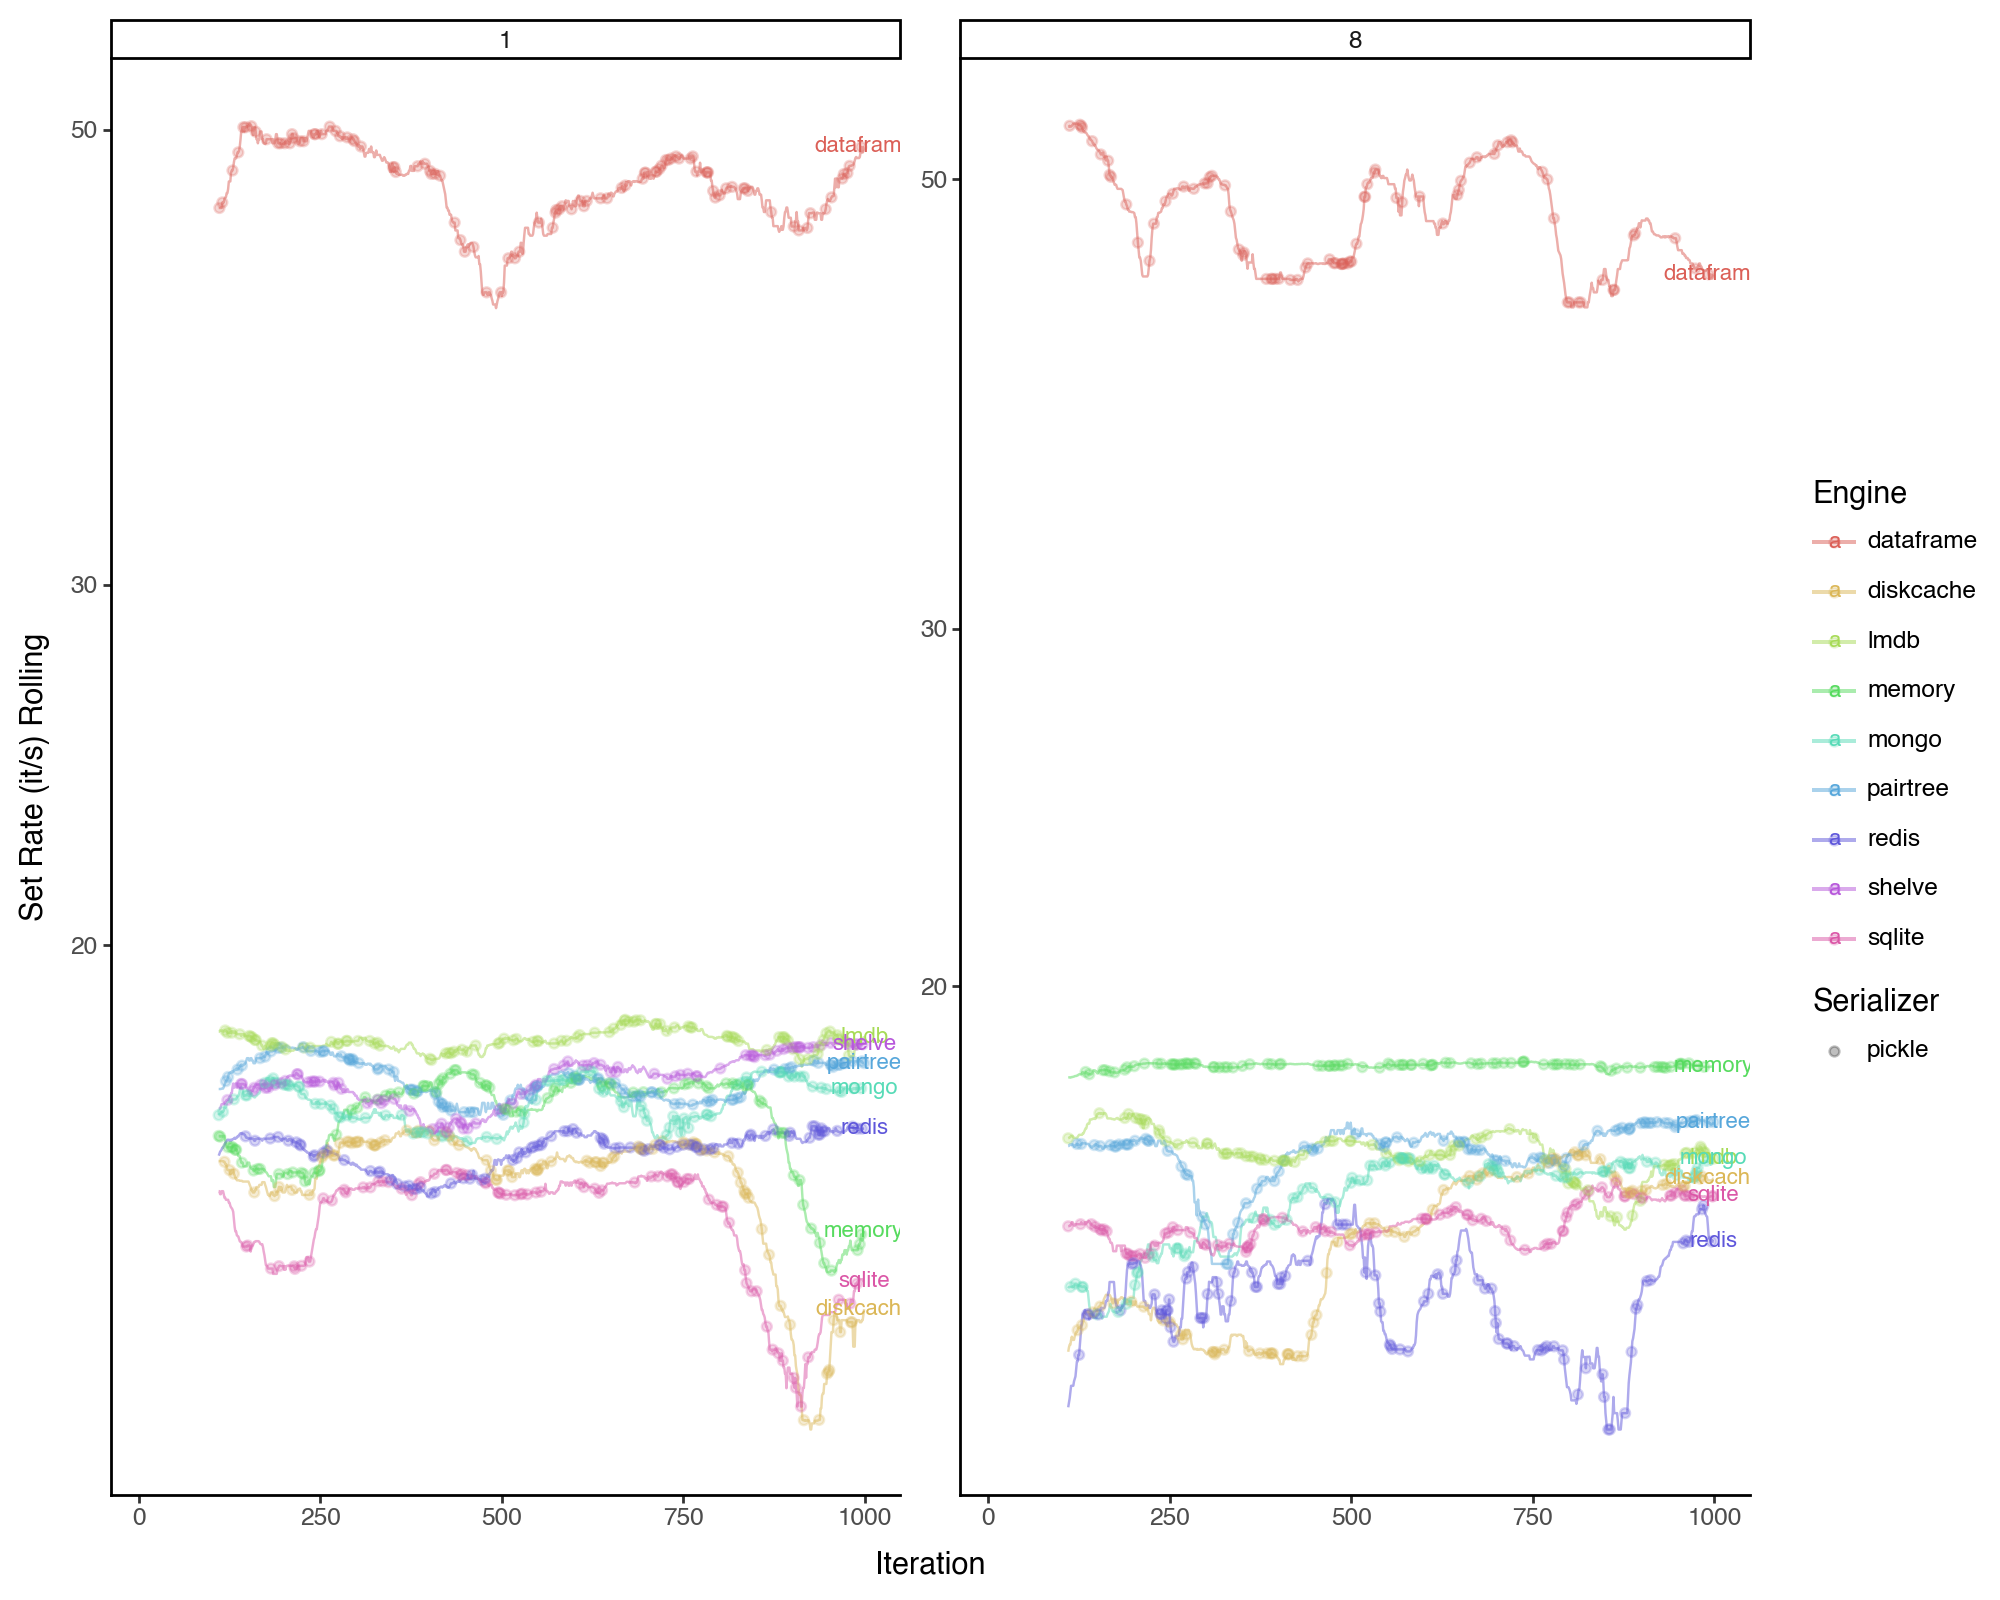

In [89]:
plot_iterations2(df, time_type='Set')